In [3]:
#%pip install ultralytics
import ultralytics
import numpy as np
import matplotlib.pyplot as plt
ultralytics.checks()

Ultralytics 8.3.39  Python-3.11.10 torch-2.5.1 CUDA:0 (NVIDIA GeForce GTX 1060, 6144MiB)
Setup complete  (8 CPUs, 15.9 GB RAM, 187.3/474.6 GB disk)


In [4]:
from ultralytics import YOLO

# Load a pretrained YOLO11n model
model = YOLO("yolo11x-obb.pt")


100%|██████████| 113M/113M [00:11<00:00, 10.4MB/s] 


In [6]:
# IMport PIL
from PIL import Image

# Load the image
img = Image.open("Test Images/tank2.png")

# Run inference on an image
results = model(img)  # results list


0: 1024x1024 215.0ms
Speed: 30.1ms preprocess, 215.0ms inference, 647.8ms postprocess per image at shape (1, 3, 1024, 1024)


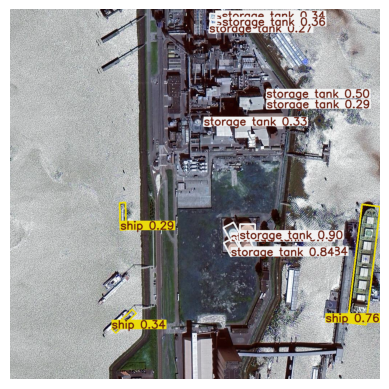

In [7]:
# Display the image using matplotlib
plt.imshow(results[0].plot())
plt.axis("off")  # Turn off axes for better visualization
plt.show()

In [8]:
import numpy as np
predictions = results[0].obb.cls

In [9]:
labels = results[0].names
predictions = predictions.detach().cpu().numpy()

In [10]:
# value counts
unique, counts = np.unique(predictions, return_counts=True)
dict(zip([labels[i] for i in unique], counts))

{'ship': np.int64(3), 'storage tank': np.int64(12)}

In [11]:
xywhrs = results[0].obb.xywhr.detach().cpu().numpy()
tanks_pos = xywhrs[predictions == 2]

In [12]:
diameters = np.mean(tanks_pos[:, 2:4], axis=1)
uncertainty = np.std(tanks_pos[:, 2:4], axis=1)

In [13]:
diameters

array([     42.427,      36.951,      36.584,      37.417,      23.537,      15.797,      15.747,      19.998,       15.49,      15.332,      23.135,      16.996], dtype=float32)

In [14]:
uncertainty

array([   0.070253,      5.0455,      5.1321,      5.9591,     0.25237,     0.29193,     0.31877,    0.047366,    0.062407,     0.10308,     0.11719,     0.36986], dtype=float32)

In [15]:
import copy

In [16]:
threshold = 0.5

In [18]:
import cv2

In [60]:

def draw_bounding_boxes(image, predictions, probs_preds, xywhrs, labels):
    """
    Draws bounding boxes and labels on the image.

    Args:
        image (np.ndarray): The original image.
        predictions (np.ndarray): Array of class predictions.
        probs_preds (np.ndarray): Array of confidence scores.
        xywhrs (np.ndarray): Array of bounding box parameters.
        labels (list): List of class names.

    Returns:
        np.ndarray: Image with drawn bounding boxes.
    """
    for cls, conf, xywhr in zip(predictions, probs_preds, xywhrs):
        # Extract box parameters
        x_center, y_center, width, height, angle = xywhr

        # Convert to int for drawing
        x_center_int, y_center_int = int(x_center), int(y_center)
        width_int, height_int = int(width), int(height)
        angle_degrees = angle * 180 / np.pi  # Convert angle to degrees

        # Define the rectangle box
        rect = ((x_center, y_center), (width, height), angle_degrees)
        box = cv2.boxPoints(rect)
        
        # Convert box to int (numpy doesn't support int0)
        box = np.array(box, dtype=int)

        # Draw the bounding box
        cv2.drawContours(image, [box], 0, (0, 255, 0), 2)

        # Put the class label and confidence score
        label_text = f"{labels[int(cls)]}: {conf:.2f}"
        cv2.putText(image, label_text, (x_center_int, y_center_int - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def calculate_diameters(xywhrs, resolution):
    """
    Calculates diameters and their uncertainty from bounding boxes.

    Args:
        xywhrs (np.ndarray): Array of bounding box parameters.
        resolution (float): Resolution in meters per pixel.

    Returns:
        np.ndarray: Array of diameters.
        float: Standard deviation of diameters (uncertainty).
    """
    wh = xywhrs[:, 2:4]
    diameters = np.mean(wh, axis=1) * resolution
    diameter_uncertainty = np.std(wh, axis=1) * resolution
    return diameters, diameter_uncertainty

In [61]:
def filter_predictions(predictions, probs_preds, xywhrs, threshold=None, class_index=None):
    """
    Filters predictions based on confidence threshold and class index.

    Args:
        predictions (np.ndarray): Array of class predictions.
        probs_preds (np.ndarray): Array of confidence scores.
        xywhrs (np.ndarray): Array of bounding box parameters.
        threshold (float, optional): Confidence threshold. Defaults to None.
        class_index (List(int), optional): Class index to filter by. Defaults to None.

    Returns:
        np.ndarray: Filtered predictions.
        np.ndarray: Filtered confidence scores.
        np.ndarray: Filtered bounding box parameters.
    """
    mask = np.ones_like(probs_preds, dtype=bool)

    if threshold is not None:
        mask &= probs_preds > threshold

    if class_index is not None:
        mask &= np.isin(predictions, class_index)            

    filtered_predictions = predictions[mask]
    filtered_probs_preds = probs_preds[mask]
    filtered_xywhrs = xywhrs[mask]

    return filtered_predictions, filtered_probs_preds, filtered_xywhrs

In [62]:

def post_process_image(results, resolution: float, threshold: float = None, class_index: int = [0, 1, 2, 6, 7, 8, 9, 10, 11]):
    """
    Post-processes the image to get object count and fuel tank diameters.

    Args:
        results: The direct output from the model.
        resolution (float): Resolution in meters per pixel.
        threshold (float, optional): Confidence threshold. Defaults to None.
        class_index (List(int), optional): Class index to filter by. Defaults to (planes, ships, storage tanks, ground track field, small vehicles, large vehicles, helicopters).

    Returns:
        dict: Dictionary containing object count, diameters, and uncertainty.
        np.ndarray: Array of diameters.
        float: Diameter uncertainty.
        np.ndarray: Image with drawn bounding boxes.
    """
    # Get the first result (assuming you have one image)
    result = results[0]

    # Get the original image
    image = result.orig_img.copy()

    # Get the predictions
    predictions = result.obb.cls.detach().cpu().numpy()
    probs_preds = result.obb.conf.detach().cpu().numpy()
    xywhrs = result.obb.xywhr.detach().cpu().numpy()
    labels = result.names

    # Filter predictions
    predictions, probs_preds, xywhrs = filter_predictions(
        predictions, probs_preds, xywhrs, threshold, class_index
    )

    # Count per class
    unique, counts = np.unique(predictions, return_counts=True)
    total_count = len(predictions)
    object_counts = dict(zip([labels[i] for i in unique], counts))

    # Draw bounding boxes on the image
    image = draw_bounding_boxes(image, predictions, probs_preds, xywhrs, labels)

    # Calculate diameters and uncertainty
    diameters, diameter_uncertainty = calculate_diameters(xywhrs, resolution) if resolution else (None, None)

    # Prepare the result dictionary
    result_dict = {
        'total_count': total_count,
        'object_counts': object_counts,
        'diameters': diameters,
        'diameter_uncertainty': diameter_uncertainty,
    }

    return result_dict, image

object_counts, image = post_process_image(results, resolution=0.1, threshold=0.2, class_index=[2])

In [63]:
object_counts

{'total_count': 12,
 'object_counts': {'storage tank': np.int64(12)},
 'diameters': array([     4.2427,      3.6951,      3.6584,      3.7417,      2.3537,      1.5797,      1.5747,      1.9998,       1.549,      1.5332,      2.3135,      1.6996], dtype=float32),
 'diameter_uncertainty': array([  0.0070253,     0.50455,     0.51321,     0.59591,    0.025237,    0.029193,    0.031877,   0.0047366,   0.0062407,    0.010308,    0.011719,    0.036986], dtype=float32)}

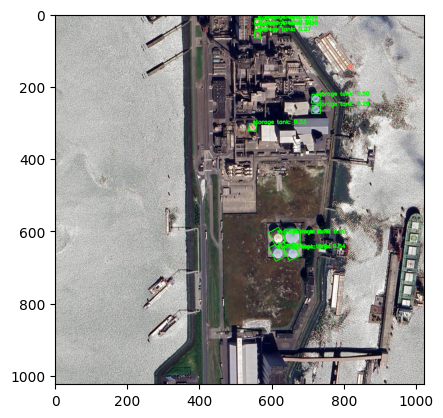

In [64]:
plt.imshow(image)
